# 观测效应仿真

观测效应仿真功能包括背景光仿真和宇宙线仿真两部分。

## 宇宙线仿真
使用CosmicRayFrameMaker()类可以生成宇宙线。在仿真中仅考虑由于mu子导致的宇宙线，这类宇宙线例子会在穿过CCD芯片时导致感光，产生长短不一的细线。
程序中假设宇宙线具有均匀且各项同性的分布。宇宙线事件的数目设置为1个事件/秒/平方厘米(参考WFPC2手册)。
能量、宽度、长度等参考Miles et al.2021、Fisher-Levine 2015等文章，分布如下图所示。
另外对于宇宙线沿路径方向的强度，我们也通过FFT的方式增加了随机性。

另外可以通过修改CosmicRayFrameMaker()类中的参数来调整宇宙线的事件几率、长度、宽度、强度分布等，具体参考代码中的注释。

In [1]:
from csst_cpic_sim import CosmicRayFrameMaker
cr_gen = CosmicRayFrameMaker()

crs = cr_gen.random_CR_parameter(10000, [1024, 1024])

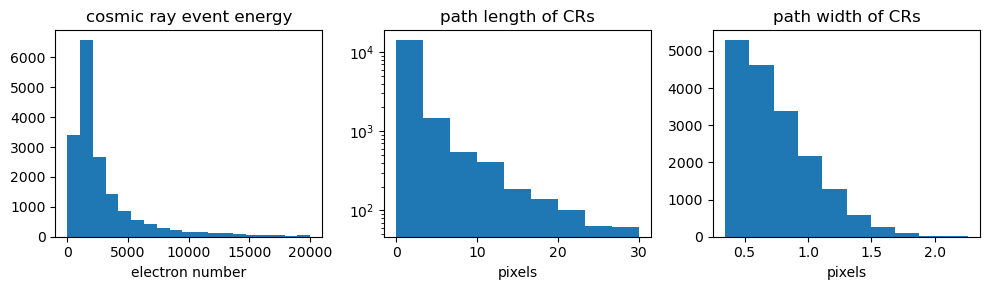

In [2]:
flux = []
length = []
angle = []
sigma = []
for cr in crs:
    flux.append(cr.flux)
    length.append(cr.length)
    angle.append(cr.angle)
    sigma.append(cr.sigma)

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

plt.figure(figsize=(10, 3))
plt.subplot(1,3,1)
plt.hist(flux, bins=np.linspace(0, 20000, 20))
plt.title('cosmic ray event energy')
plt.xlabel('electron number')
plt.subplot(1,3,2)
plt.hist(length, bins=np.linspace(0, 30, 10), log=True)
plt.title('path length of CRs')
plt.xlabel('pixels')
plt.subplot(1,3,3)
plt.hist(sigma)
plt.title('path width of CRs')
plt.xlabel('pixels')
plt.tight_layout()

使用该类的make_cr_frame()方法可以生成宇宙线图像。
该方法包括两个参数，分别为相机芯片尺寸和曝光时间。下面的代码演示了如何生成宇宙线图像。生成的宇宙线图像为一个二维数组，单位为电子数。


图中仿真了分别为30s曝光和300s曝光的两幅宇宙线图像。

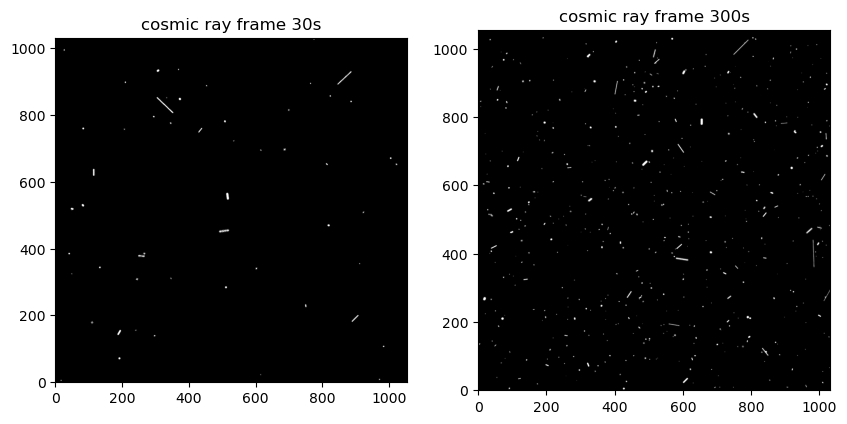

In [3]:
def psf_imshow(psf, vmin=1e-8, vmax=0.1):
    focal_img = psf.copy()
    focal_img = np.maximum(focal_img, vmin)
    focal_img = np.minimum(focal_img, focal_img.max()*vmax)
    # image_log = np.log10(focal_img)
    image_log = focal_img
    plt.imshow(image_log, origin='lower', cmap='gray')

plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
crframe = cr_gen.make_cr_frame([1032, 1056], 30)
psf_imshow(crframe, vmin=0, vmax=0.01)
plt.title('cosmic ray frame 30s')

plt.subplot(1,2,2)
crframe_300 = cr_gen.make_cr_frame([1056, 1032], 300)
psf_imshow(crframe_300, vmin=0, vmax=0.01)
plt.title('cosmic ray frame 300s')

fits.writeto('image_files/cr_frame_30s.fit', crframe, overwrite=True)

sky_frame_maker()函数可以生成天空背景图像，输入参数为观测波段、对应波段的星等/平方角秒、焦面比例尺、图像大小。
程序中天空背景光谱按照太阳光谱估计、考虑仪器的整体光电效率。输出为一个二维数组，反应了焦面处的辐照密度，单位为电子数/秒/平方米。
注意需要乘上望远镜通光口径和曝光时间来得到电子数。

Text(40, 40, '0.029 photons/pixel/s')

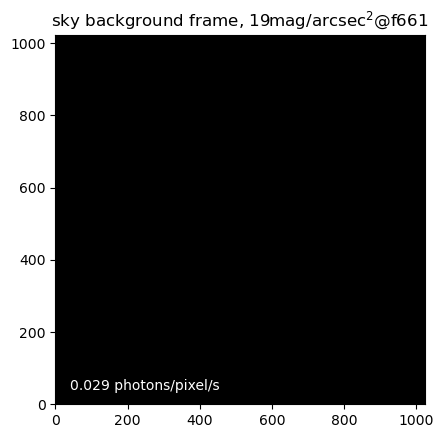

In [5]:
from csst_cpic_sim import sky_frame_maker

area = 3.14 * 100 ** 2
frame = sky_frame_maker('f661', 19, 0.01613, (1024, 1024)) * area
psf_imshow(frame)
plt.title('sky background frame, 19mag/arcsec$^2$@f661')
plt.text(40, 40, f'{frame[1,1]:.3f} photons/pixel/s', color='white')